In [57]:
from diffusers import StableDiffusionXLPipeline
import torch
import importlib
import sd_hooks
importlib.reload(sd_hooks)
from sd_hooks import SDHiddenRecorder
from typing import Literal
from modules import namespace
from typing import Literal

In [2]:
pipeline: StableDiffusionXLPipeline = StableDiffusionXLPipeline.from_single_file(
    "/root/ComfyUI/models/checkpoints/animagine-xl-3.1.safetensors", 
    torch_dtype=torch.float16, 
    variant="fp16", 
    safety_checker=None, 
    config='/root/ComfyUI/models/checkpoints/Animagine3.1',
).to("cuda")
torch.manual_seed(42)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
def get_resnet_id(part: Literal['down', 'up', 'mid'], block_n: int, resnet_n: int):
    result = f'{part}_blocks.{block_n}.resnets.{resnet_n}'
    assert result in namespace
    return result

In [4]:
get_resnet_id('up', 0, 0)

'up_blocks.0.resnets.0'

In [60]:
hidden_ids = [
    'up_blocks.0.resnets.0',
    'up_blocks.0.resnets.1',
    'up_blocks.0.resnets.2',
    'up_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q',
    'down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_q',
    'mid_block'
]

In [61]:
recorder = SDHiddenRecorder(pipeline, hidden_ids)
generator = torch.Generator("cuda").manual_seed(31)
prompt = "1 girl, looking at viewer"
negative_prompt = "bad anatomy,blurry,(worst quality:1.8),low quality,hands bad,face bad,(normal quality:1.3),bad hands,mutated hands and fingers,extra legs,extra arms,duplicate,cropped,text,jpeg,artifacts,signature,watermark,username,blurry,artist name,trademark,title,multiple view,Reference sheet,long body,multiple breasts,mutated,bad anatomy,disfigured,bad proportions,duplicate,bad feet,artist name,ugly,text font ui,missing limb,monochrome,"
with torch.no_grad():
    image = pipeline(
    prompt=prompt, 
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    callback_on_step_end=recorder,
    generator=generator
).images[0]
recorder.hiddens.pop()

Hooking down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_q
Hooking up_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q
Hooking up_blocks.0.resnets.0
Hooking up_blocks.0.resnets.1
Hooking up_blocks.0.resnets.2
Hooking mid_block


  0%|          | 0/20 [00:00<?, ?it/s]

{}

In [65]:
recorder.hiddens[1]['mid_block'].shape

torch.Size([2, 1280, 32, 32])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

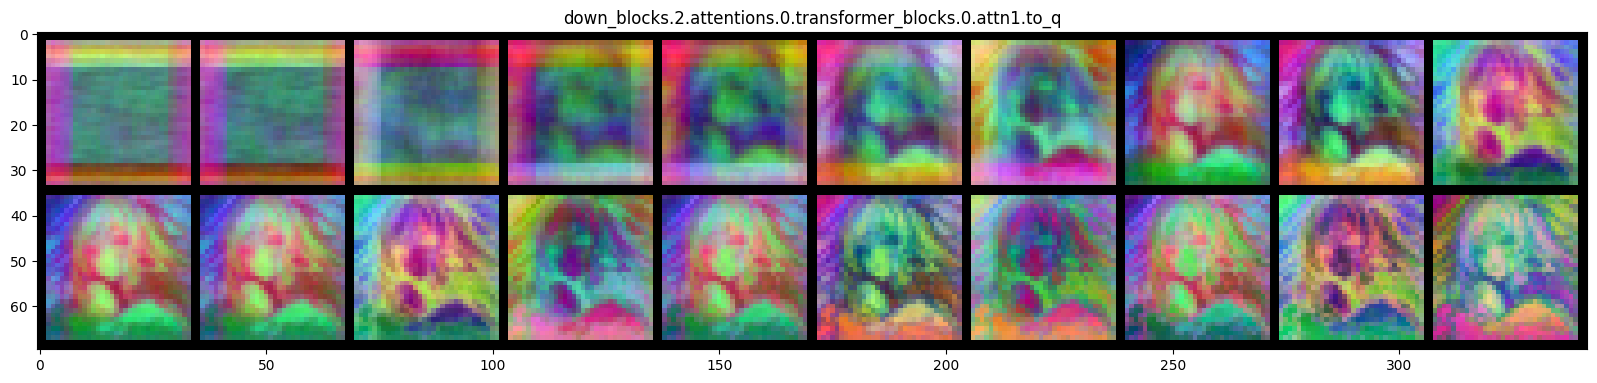

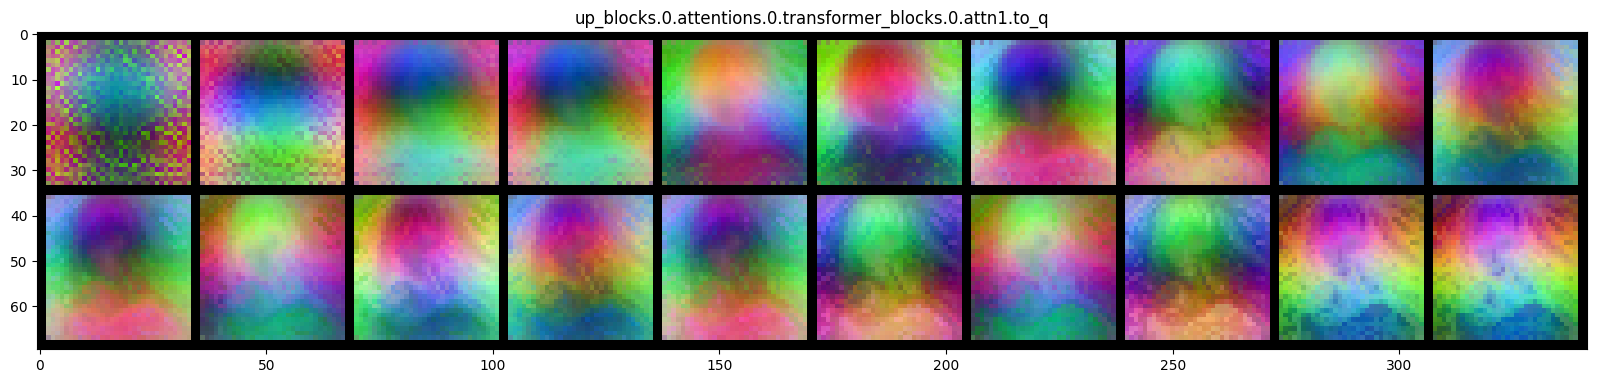

In [66]:
recorder.qkv_visualization('down_blocks.2.attentions.0.transformer_blocks.0.attn1.to_q')
recorder.qkv_visualization('up_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q')


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

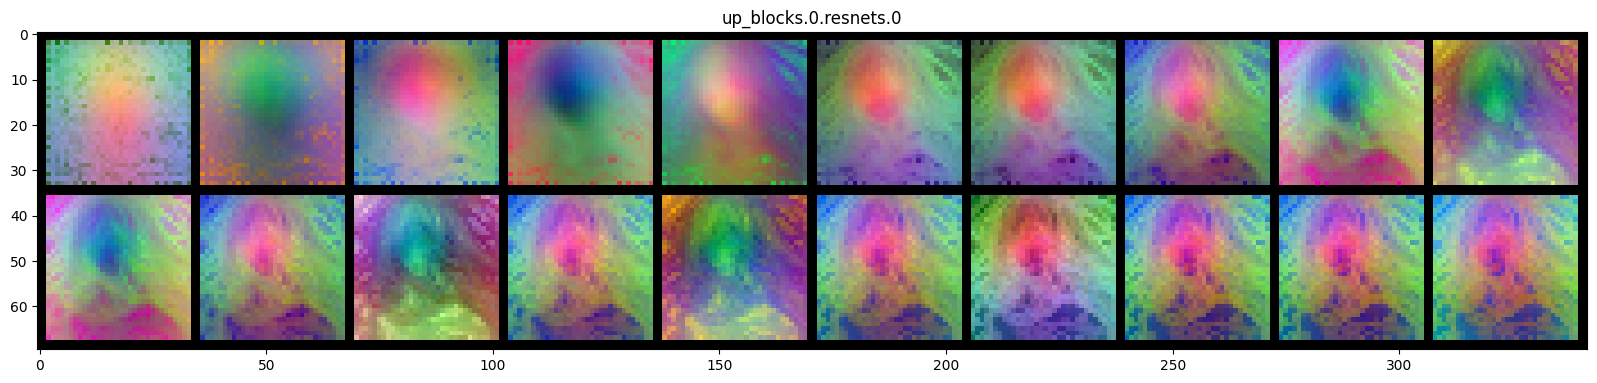

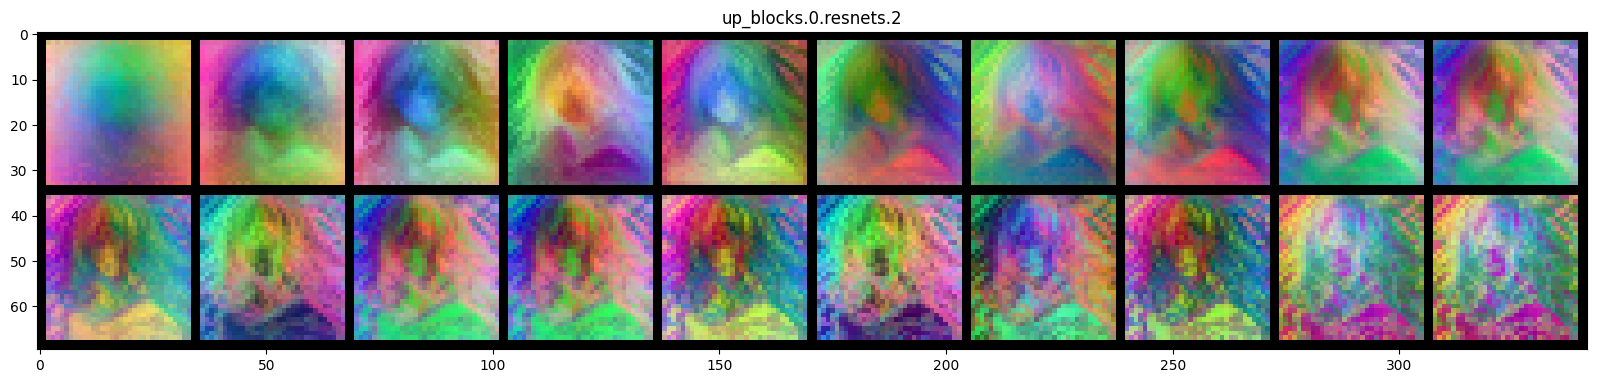

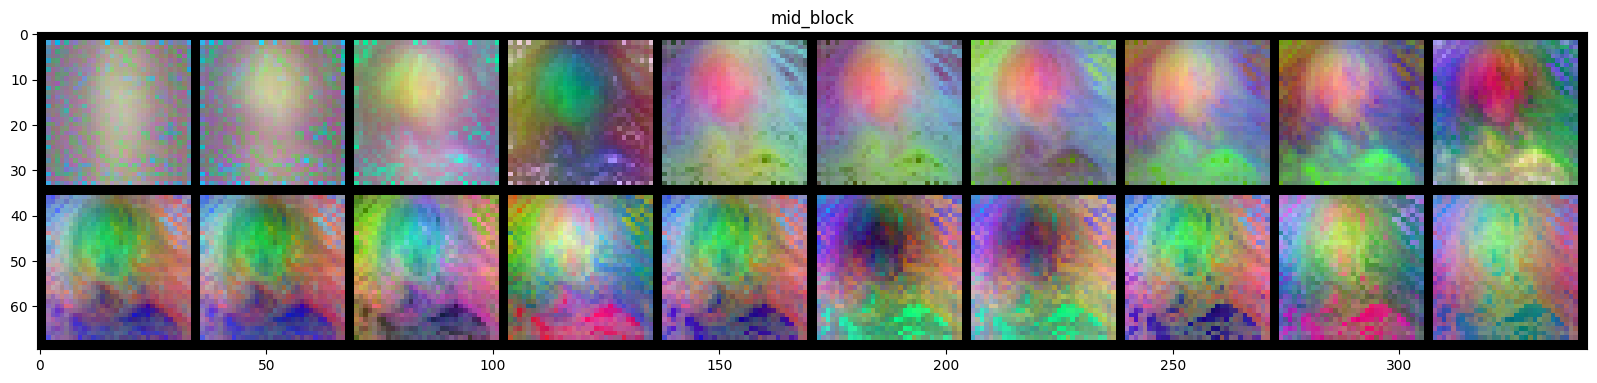

In [68]:
recorder.feature_visualization('up_blocks.0.resnets.0')
recorder.feature_visualization('up_blocks.0.resnets.2')
recorder.feature_visualization('mid_block')

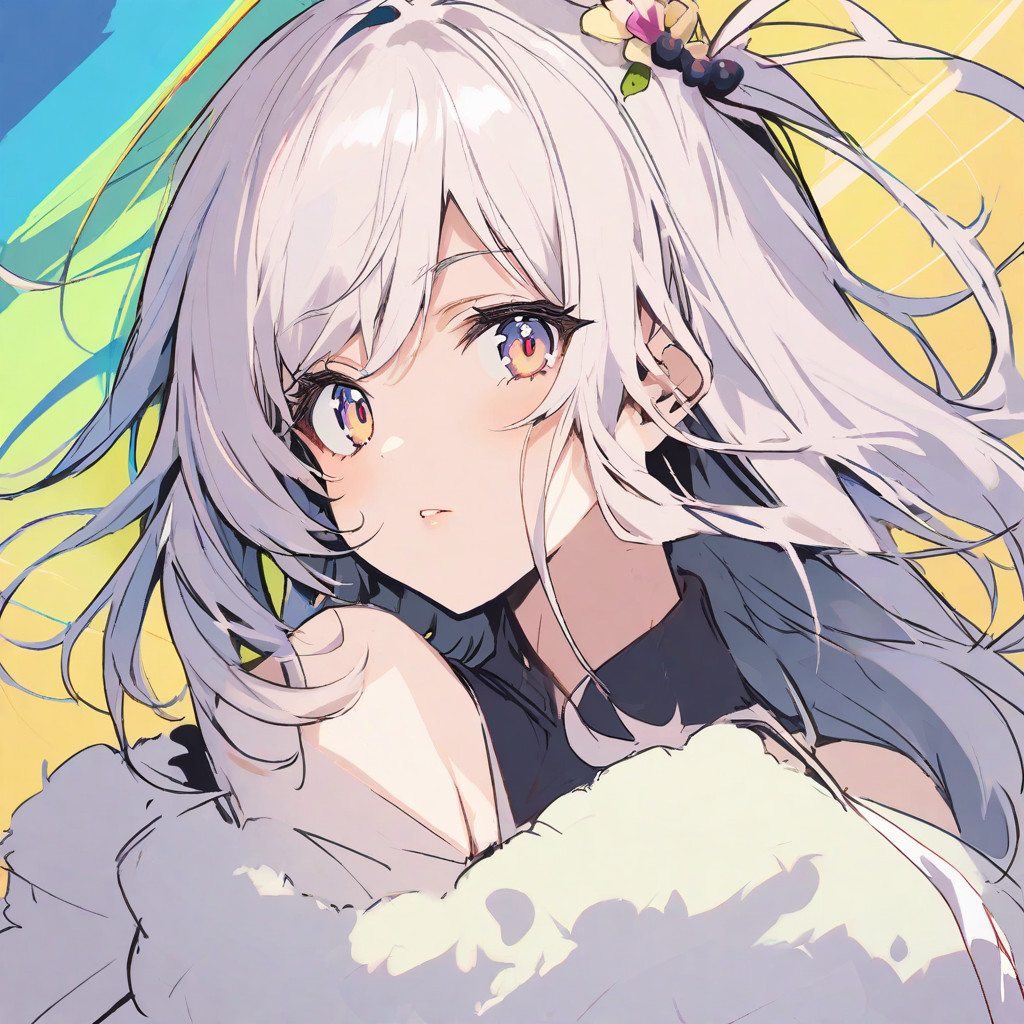

In [55]:
image